# Table of Contents
 <p><div class="lev1"><a href="#Derive-scaling"><span class="toc-item-num">1&nbsp;&nbsp;</span>Derive scaling</a></div>

In [1]:
%load_ext autoreload
%matplotlib inline

In [82]:
%autoreload 2

import numpy as np
import dask.array as da
import matplotlib.pyplot as plt
import datetime as dt
import sys,os,glob
from mpl_toolkits.basemap import Basemap
from matplotlib.colors import LogNorm
from scipy.stats import gaussian_kde

## Add own library to path
workdir = os.getcwd()
moduledir = os.path.join(os.path.dirname(workdir),'functions')
sys.path.insert(0,moduledir)
print("Own modules available:", [os.path.splitext(os.path.basename(x))[0]
                                 for x in glob.glob(os.path.join(moduledir,'*.py'))])
## Load own libraries
from thermoConstants import *
from environmentAndDirectories import *
from importingData import *
from scalingApproximations import *
from slicingAndSubsetting import *
from statisticalDistributions import *

Own modules available: ['CAMsettings', 'daskOptions', 'environmentAndDirectories', 'importingData', 'outputResults', 'physicalConstants', 'plot1DInvLog', 'plot2D', 'plotMaps', 'scalingApproximations', 'slicingAndSubsetting', 'statisticalDistributions', 'thermoConstants', 'thermoFunctions']


In [27]:
compset = 'FAMIPC5'
experiment = 'piControl'
subset = 'tropics'
time_stride = 'day'
resolution = '1dx'
daskarray = False
tracktime = True
dates = ('185005010100','185005020000')

historyFilesSettings = getCAMHistoryFilesSettings()
handle = 'h0'
inputdir, inputdir_processed_day, inputdir_processed_1hr, inputdir_results, inputdir_fx = \
    getInputDirectories(compset,experiment)

    
q_id = 'Q'
spechum = getValues(q_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
omega_id = 'OMEGA'
omega = getValues(omega_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pr_id = 'PRECT'
pr = getValues(pr_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
# ts_id = 'TS'
# ts = getValues(ts_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
relhum_id = 'RELHUM'
relhum = getValues(relhum_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
ta_id = 'T'
ta = getValues(ta_id,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)

Importing Q from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing OMEGA from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing PRECT from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing RELHUM from 24 history files between 1850-05-01-03600 and 1850-05-02-00000
Importing T from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


In [28]:
## Get longitude, latitude and landmask

fh = Dataset(os.path.join(inputdir_fx,'landmask_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc'))
lon1D = fh.variables['lon'][:]
lat1D = fh.variables['lat'][:]
lon2D, lat2D = np.meshgrid(lon1D,lat1D)

print("Loading lontigude, latitude and landmask")

landmask = fh.variables['landmask']


Loading lontigude, latitude and landmask


In [29]:
input_lev_file = os.path.join(inputdir_fx,'lev_fx_CESM111-SPCAM20_allExperiments_r0i0p0.nc')
computeP = getPressureCoordinateFunction(input_lev_file)

In [30]:
ps_varid = 'PS'
ps = getValues(ps_varid,compset,subset,experiment,time_stride,resolution,daskarray=daskarray,dates=dates,handle=handle)
pres = computeP(ps)
cn = getArrayType(pres)

Importing PS from 24 history files between 1850-05-01-03600 and 1850-05-02-00000


# Derive scaling

In [34]:
%%time
print("Compute ranks and ranks locations")

n_pts = pr.size
Q_IL = getInvLogRanks(n_pts,n_pts_per_bin=1,fill_last_decade=True)
i_Q = indexOfRank(99.9,Q_IL)
iQ_slice = slice(i_Q-5,i_Q+5)
ranks, centers, bins = computePercentilesAndBinsFromRanks(pr.flatten(),Q_IL)
iQ_min = 8
iQ_max = min(len(Q_IL),41)
# iQ_max = min(len(Q_IL),iQ_slice.stop)

# Define reference percentiles and compute percentiles
targetranks = Q_IL[iQ_min:iQ_max]
ranks_ref = Q_IL[:iQ_max]
percentiles = adjustRanks(centers,ranks,ranks_ref)

# Suffix to save figures and results
output_suffix = 'Q%d-Q%d_%s'%(iQ_min,iQ_max,'-'.join(dates))

rank_locations= {}
for rank in ranks_ref:
    rank_id  = "%2.4f"%rank
    print(rank_id,end=' ')
    rank_locations[rank_id] = getRankLocations(rank,pr,ranks,bins,rank_locations)
print()

Compute ranks and ranks locations
0.0000 20.5672 36.9043 49.8813 60.1893 68.3772 74.8811 80.0474 84.1511 87.4107 90.0000 92.0567 93.6904 94.9881 96.0189 96.8377 97.4881 98.0047 98.4151 98.7411 99.0000 99.2057 99.3690 99.4988 99.6019 99.6838 99.7488 99.8005 99.8415 99.8741 99.9000 99.9206 99.9369 99.9499 99.9602 99.9684 99.9749 99.9800 99.9842 99.9874 99.9900 
CPU times: user 14.4 ms, sys: 5.7 ms, total: 20.1 ms
Wall time: 20 ms


In [83]:
ta_prQ999 = meanXProfileAtRank(99.9,ta,pr,ranks_ref,rank_locations=rank_locations)
pres_prQ999 = meanXProfileAtRank(99.9,pres,pr,ranks_ref,rank_locations=rank_locations)
omega_prQ999 = meanXProfileAtRank(99.9,omega,pr,ranks_ref,rank_locations=rank_locations)

In [42]:
values = ta
ind = getRankLocations(99.9,pr,ranks,bins,rank_locations)
vshape = values.shape
ndims = len(vshape)
ishape = ind.shape
nlev = vshape[1]
ind = cn.repeat(ind[:,np.newaxis,...],nlev,1); print(ind.shape)

v_nan = np.copy(values)
v_nan[ind != 1] = np.nan
dimorder = [1,0]+list(range(2,ndims))
print(cn.transpose(v_nan,dimorder).shape)
cn.nanmean(cn.transpose(v_nan,dimorder).reshape(nlev,-1),axis=1)

(1, 30, 32, 144)
(30, 1, 32, 144)


array([ 244.38562012,  234.19950867,  227.40519714,  219.16773987,
        211.69793701,  202.57481384,  193.59069824,  195.89961243,
        190.14666748,  190.86102295,  197.69451904,  206.03923035,
        215.05529785,  224.83305359,  234.90736389,  244.52372742,
        253.48895264,  261.58261108,  268.38491821,  273.26211548,
        277.08901978,  282.03549194,  285.59829712,  287.82131958,
        289.30706787,  290.68048096,  292.10464478,  293.5647583 ,
        294.98977661,  296.08517456], dtype=float32)

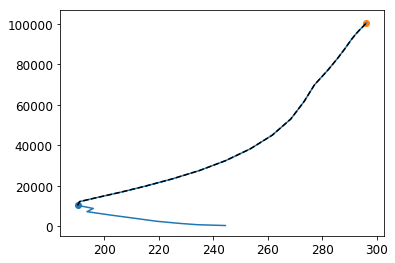

In [94]:
plt.plot(ta_prQ999,pres_prQ999)
plt.scatter(ta_prQ999[i],pres_prQ999[i])
plt.scatter(ta_prQ999[j],pres_prQ999[j])
plt.plot(ta_prQ999_c,pres_prQ999_c,'k--')

In [19]:
levdim = 1 
omega_pos = omega.copy()
omega_pos[omega > 0] = 0
qvstar = saturationSpecificHumidity(ta,pres)
dqvstar = cn.diff(qvstar,axis=levdim)
dq = cn.diff(spechum,axis=levdim)
dp = cn.diff(pres,axis=levdim) 
dq_dp = dq/dp
dqvstar_dp = dqvstar/dp

In [33]:
pr_est = -verticalPressureIntegral(pres,values=[omega],dvdp=dqvstar_dp,levdim=levdim)
pr_est_pos_omega = -verticalPressureIntegral(pres,values=[omega_pos],dvdp=dqvstar_dp,levdim=levdim)
detrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg
detrained_est_pos_omega = verticalPressureIntegral(pres,values=[omega_posdetrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/ggdetrained_est = verticalPressureIntegral(pres,values=[omega,1-relhum,qvstar],levdim=levdim)/gg,1-relhum,qvstar],levdim=levdim)/gg

In [14]:
pr_est.max().compute()
pr.max().compute()

7.953401e-07

In [82]:
print(np.isnan(pr).size,np.isnan(pr_est).size)

18432 18432


In [60]:
# Compute regression lines

x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)

In [81]:
from scipy.stats import linregress

above = pr > 5e-8
# x,y = pr_est.reshape(1,-1),pr.reshape(1,-1)
x,y = pr_est[above],pr[above]
slope, intercept, r_value, p_value, std_err = linregress(x, y)
print(slope, intercept, r_value, p_value, std_err)

0.00185416334883 1.12303717493e-07 0.51016748263 1.03412344845e-283 4.7680233789e-05


ValueError: Invalid RGBA argument: 166378377119.41626

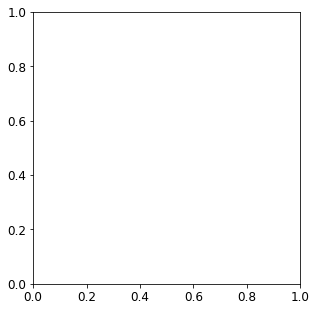

In [85]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

x_lims = (-1e-4,1e-4)
x_vals = np.linspace(x_lims[0],x_lims[1],100)

x,y = pr_est[above],pr[above]
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

plt.scatter(pr_est,pr,c=z,s=100,edgecolor='')
plt.plot(x_vals,(slope*x_vals+intercept))
plt.xlim((-1e-4,1e-4))
plt.ylim((-1e-7,1e-6))


ax = fig.add_subplot(122)

plt.scatter(pr_est_pos_omega,pr)
plt.ylim((-1e-7,1e-6))
plt.xlim((-1e-4,1e-4))

(-0.0002, 0.0002)

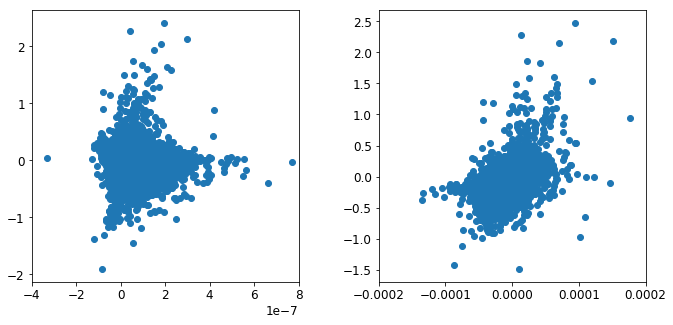

In [80]:
fig = plt.figure(figsize=(11,5))

ax = fig.add_subplot(121)

plt.scatter(pr-slope*pr_est,detrained_est)
plt.xlim((-4e-7,8e-7))
# plt.ylim((-1e-4,1e-4))

ax = fig.add_subplot(122)

plt.scatter(pr-pr_est_pos_omega,detrained_est_pos_omega)
plt.xlim((-2e-4,2e-4))
# plt.ylim((-1e-4,1e-4))